# Data Preprocessing

In [206]:
import os
import statistics
import torch
import math
from Bio import SeqIO
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas as pd
import re
from functools import reduce
import numpy as np
import seaborn as sn


In [4]:
fasta_file = 'trna/trna.fa'

In [5]:
len(fasta_file)

12

In [6]:
n = 0 
for rec in SeqIO.parse(fasta_file, "fasta"):
    n+= 1

In [7]:
n #the number of sequences in our file

27818

In [8]:
trnas = []
fasta_file = 'trna/trna.fa'
for record, num in zip(SeqIO.parse(fasta_file, "fasta"), range(n)):
        trnas.append(str(record.seq).upper())

random.seed(42)
random.shuffle(trnas)
trnas = trnas[:10000]
trnas= [re.sub(r'.*[^GCTAN].*', '', s) for s in trnas] #replaces strings w/ non bases with empty string


In [9]:
K = [s for s in trnas if 'NNNNNNN' in s]
trnas = [i for i in trnas if i not in K] #remove sequences with long sequences of NNNNNNN

while('' in trnas):  #remove empty sequences
    trnas.remove('')

In [10]:
#trnas

In [11]:
#type(trnas)

In [12]:
maximum = max(len(s) for s in trnas)

In [13]:
maximum

601

In [14]:
min(len(s) for s in trnas)

55

In [15]:
avg = math.ceil(statistics.mean(len(s) for s in trnas)) #find the average length of sequences

In [16]:
avg

78

In [17]:
for i,s in enumerate(trnas):  #either pad or cut from the sequence so they are the same length 
    if len(s) < avg:
        pad = avg- len(s)
        s += 'N' * pad
        trnas[i] = s
    elif len(s) > avg:
        s = s[:avg]
        trnas[i] = s

In [18]:
#trnas
#df = pd.DataFrame(trnas)
#df.to_clipboard(index=False,header=False)

In [19]:
N = torch.zeros((avg, 5),  dtype = torch.int32) #create a 5 by sequence length torch matrix

In [20]:
bases = ['A','T','C','G','N']

In [21]:
stoi = {'A': 0, 'T': 1, 'C':2, 'G':3, 'N':4}
itos = {i:s for s,i in stoi.items()}

In [22]:
for seq in trnas: ##get the nucleotide count for each position
    for i, b in enumerate(seq):
        ix2 = i # the row number
        ix1 = stoi[b]
        N[ix2][ix1] += 1

In [24]:
N = N+1 # element wise addition (so we dont have any 0 frequency)

In [ ]:
plt.figure(figsize = (50,50))
plt.imshow(N, cmap = 'Reds')
for i in range(5):
    for j in range(avg):
        plt.text(i, j, itos[i], ha = 'center', va = 'bottom', color = 'gray') #horizontal and vertical alognments
        plt.text(i, j, N[j, i].item(), ha = 'center', va = 'top', color = 'gray') # the count at the bottom
plt.axis('off');



In [26]:
P = N.float() #Get the probabilities
P /= P.sum(1, keepdims = True) 

In [27]:
P.shape

torch.Size([78, 5])

In [ ]:
plt.figure(figsize = (50,50))
plt.imshow(P, cmap = 'Blues')
for i in range(5):
    for j in range(avg):
        plt.text(i, j, itos[i], ha = 'center', va = 'bottom', color = 'gray') #horizontal and vertical alognments
        plt.text(i, j, round(P[j, i].item(),2), ha = 'center', va = 'top', color = 'gray') # the count at the bottom
plt.axis('off');

In [32]:
P[0][stoi['N']].item()

0.0010037136962637305

# Training the model

In [134]:
trna_avgs = []
for seq in trnas:
    m = 0.0
    for row, base in enumerate(seq):
        col = stoi[base]
        m += torch.log(P[row][col])
    trna_avgs.append(m)

#https://cs.stackexchange.com/questions/77135/why-is-adding-log-probabilities-faster-than-multiplying-probabilities

In [120]:
trna_avgs

[tensor(-61.3718),
 tensor(-69.0000),
 tensor(-60.9627),
 tensor(-65.9479),
 tensor(-103.0283),
 tensor(-66.7518),
 tensor(-63.0877),
 tensor(-63.0773),
 tensor(-61.7390),
 tensor(-57.5178),
 tensor(-84.8236),
 tensor(-83.3061),
 tensor(-120.0071),
 tensor(-115.1261),
 tensor(-73.6043),
 tensor(-114.4878),
 tensor(-114.8277),
 tensor(-77.6320),
 tensor(-98.0351),
 tensor(-86.8141),
 tensor(-105.4940),
 tensor(-85.8615),
 tensor(-69.2641),
 tensor(-112.3127),
 tensor(-97.4571),
 tensor(-100.2045),
 tensor(-117.0248),
 tensor(-68.4234),
 tensor(-105.4000),
 tensor(-72.9496),
 tensor(-58.7561),
 tensor(-136.2776),
 tensor(-68.5887),
 tensor(-76.9637),
 tensor(-74.6364),
 tensor(-138.3766),
 tensor(-120.0496),
 tensor(-106.9726),
 tensor(-126.0603),
 tensor(-113.8610),
 tensor(-78.7129),
 tensor(-83.9497),
 tensor(-74.8226),
 tensor(-104.6868),
 tensor(-59.2769),
 tensor(-69.6829),
 tensor(-113.5337),
 tensor(-84.0615),
 tensor(-68.6564),
 tensor(-75.6522),
 tensor(-136.1386),
 tensor(-67.

In [152]:
t = torch.stack(trna_avgs).numpy()
sum = reduce(lambda x, y: x + y, t)

In [153]:
sum

-868632.75

In [155]:
sum/len(trna_avgs) #the mean average

-87.27346026323721

In [158]:
min(t), max(t)

(-184.4414, -57.375534)

(array([3.000e+00, 1.000e+00, 5.000e+00, 1.800e+01, 8.400e+01, 4.100e+02,
        6.370e+02, 5.580e+02, 7.930e+02, 7.390e+02, 3.970e+02, 7.450e+02,
        1.028e+03, 2.254e+03, 2.281e+03]),
 array([-184.44140625, -175.97035217, -167.49928284, -159.02822876,
        -150.55717468, -142.08612061, -133.61505127, -125.14399719,
        -116.67294312, -108.20188141,  -99.73082733,  -91.25976562,
         -82.78871155,  -74.31764984,  -65.84659576,  -57.37553406]),
 <BarContainer object of 15 artists>)

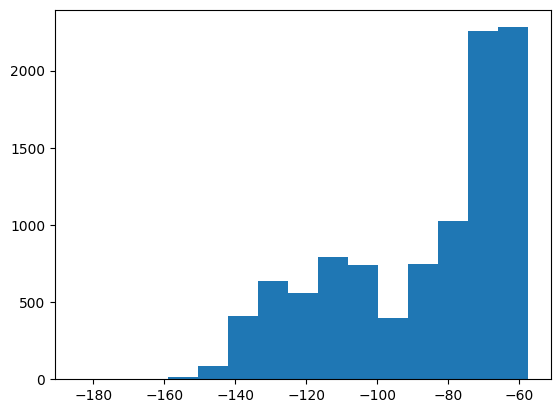

In [160]:
plt.hist(t, bins = 15)

# Testing the model

## Create yes and no tRNA datasets

In [97]:
threshold = min(trna_avgs)

testing_yes = trnas[-200:]
testing_yes = [(s, 1) for s in trnas] 




In [191]:
threshold

tensor(3.8572e-16)

In [164]:
testing_no = []
for _ in range(200):
    np_values = np.asarray(['A', 'T', 'C', 'G'])
    np_count = np.asarray([1, 1, 1, 1])
    np_urn = np.repeat(np_values, np_count)
    N = avg
    sequence = np.random.choice(np_urn, size=N, p=None, replace=True)
    sequence = ''.join(sequence)
    testing_no.append((sequence, 0))


In [165]:
testing_no

[('GAACGGGATACCTACGCCTCCTAGTTCAATCGAGAGTCGTTACCATCTGGGTGGAGCATTGCGTATACGATTCCATCA',
  0),
 ('CAGACATCCTTTAGTGACCACGTGTACTAGAGAGCATAATTAGCGAGTGTTAGCCCATATGTCCTGCTACGCGACTAC',
  0),
 ('AGAAAACGCATTCAAGGACAAAGGAGGAATTATATATCGCTGGCCAACTCTTTAACAGGACTCATATTCTACAGACGG',
  0),
 ('CCGATGAAGTTGTGAGACCCACAGGACCAGTACTCGCGTGGGACTCGGTTCACTGATTGAACTGAGGCAAATCAGCGT',
  0),
 ('TACTAAATTAAGACCACCGATAGTCGTATCACACTTTATGGACTAAACAGGATTGCTTACTTGGGTTATAAACTGGGC',
  0),
 ('TATCTTCAAGGCAGGGTTAAACTGATTTTCCGTTCGTTATTAACCTCTGGACAATTATTACTTGGACAACGAGACATG',
  0),
 ('TGCCGCGAGTGGGTAACCCGTCTTCTGGTTTAATGCTTTATGTTTGTGAGAACAGCACGTCGTCATTAGAAGTCTCTA',
  0),
 ('ATGCTCTGTGAGGACCTGTAATTCAGCGGCCAAATTTAAATCCCAGGATACAGGATCATCTCTTCTTAGTCTGATTCA',
  0),
 ('AACTCTAAGTCCTGGTGAGTGCGGAAGCAGACACATTCCAAGAGCTTGCCCTCTGTTTGGGGGAGGAAATCCCCGCTT',
  0),
 ('TTCTTTCCCACAGACGGTTGAGGCTTTTGCCTCTCATCCCCATCCCTTCGATAAATAAGAACAGGCTGAGCGCACTGC',
  0),
 ('GATTTACGGGACCCTAAAGCCCCCTTTTCGGATCGGTTGGGCATGTCTGGTTAACCCTAACCCTCAGTTGAACTCCTC',
  0),
 ('GTTTCCT

In [174]:
res_n = []

for s in (testing_no): #s is a tuple
    seq = s[0] 
    prob = 0.0
    for row, base in enumerate(seq):
        col = stoi[base]
        prob += torch.log(P[row][col])
    res_n.append(prob)

In [175]:
res_n

[tensor(-140.5088),
 tensor(-151.3084),
 tensor(-135.2315),
 tensor(-151.2531),
 tensor(-145.6985),
 tensor(-134.3748),
 tensor(-153.4508),
 tensor(-140.0084),
 tensor(-134.9807),
 tensor(-136.3077),
 tensor(-136.9600),
 tensor(-141.2543),
 tensor(-131.4319),
 tensor(-144.7160),
 tensor(-150.0554),
 tensor(-136.2175),
 tensor(-137.9427),
 tensor(-134.8180),
 tensor(-136.0431),
 tensor(-145.8767),
 tensor(-145.1019),
 tensor(-132.0815),
 tensor(-126.5511),
 tensor(-132.8759),
 tensor(-133.1474),
 tensor(-147.2878),
 tensor(-140.9080),
 tensor(-156.5533),
 tensor(-141.6744),
 tensor(-136.8225),
 tensor(-135.0844),
 tensor(-130.1167),
 tensor(-142.5958),
 tensor(-138.7758),
 tensor(-131.2031),
 tensor(-135.0209),
 tensor(-130.9119),
 tensor(-135.5559),
 tensor(-135.9331),
 tensor(-140.4552),
 tensor(-141.4280),
 tensor(-151.2404),
 tensor(-141.8260),
 tensor(-142.7603),
 tensor(-140.0855),
 tensor(-139.4534),
 tensor(-143.0093),
 tensor(-140.2295),
 tensor(-141.7217),
 tensor(-133.9312),


In [179]:
res_y = []

for s in (testing_yes): #the sequences themselves
    seq = s[0]
    prob = 1.0
    for row, base in enumerate(seq):
        col = stoi[base]
        prob *= torch.log(P[row][col])
    res_y.append(prob)



In [180]:
res_y

[tensor(1.7016e-14),
 tensor(5.3531e-11),
 tensor(1.8528e-14),
 tensor(4.6241e-13),
 tensor(77.3182),
 tensor(4.9414e-12),
 tensor(1.3111e-13),
 tensor(3.8945e-14),
 tensor(2.7580e-14),
 tensor(3.8572e-16),
 tensor(0.0002),
 tensor(3.4508e-06),
 tensor(27000008.),
 tensor(782266.6875),
 tensor(1.6944e-09),
 tensor(859134.6875),
 tensor(2267141.5000),
 tensor(7.7150e-08),
 tensor(0.4869),
 tensor(0.0001),
 tensor(358.4786),
 tensor(6.5948e-05),
 tensor(6.4132e-11),
 tensor(997111.),
 tensor(0.2680),
 tensor(14.5894),
 tensor(41251816.),
 tensor(3.1683e-11),
 tensor(520.0793),
 tensor(2.6442e-10),
 tensor(1.2824e-15),
 tensor(9.6968e+13),
 tensor(1.7327e-11),
 tensor(7.9169e-09),
 tensor(7.7173e-09),
 tensor(9.8756e+12),
 tensor(7492990.5000),
 tensor(6098.5659),
 tensor(11341464.),
 tensor(330523.2188),
 tensor(2.4798e-08),
 tensor(8.5117e-05),
 tensor(2.3567e-09),
 tensor(108.2614),
 tensor(1.7311e-15),
 tensor(1.0676e-10),
 tensor(138918.7031),
 tensor(9.3929e-07),
 tensor(3.8607e-12)

In [182]:
min(res_y), max(res_y) #the yes data

(tensor(3.8572e-16), tensor(4.0479e+19))

In [185]:
t = torch.stack(res_y).numpy()
sum = reduce(lambda x, y: x + y, t)

In [186]:
sum/len(res_y)

1.2023918028844866e+16

In [188]:
min(res_n), max(res_n) # the no data 

(tensor(-156.5533), tensor(-123.4728))

In [189]:
t = torch.stack(res_n).numpy()
sum = reduce(lambda x, y: x + y, t)

In [190]:
sum/len(res_n)

-138.555966796875

# Stats

In [199]:
rates = {'TN': 0, 'TP' : 0, 'FN': 0, 'FP':0}

for y, n in zip(res_y, res_n):
    print(y.item(), n.item())
    if y.item() >= threshold:
        rates['TP'] += 1
    if n.item() >= threshold:
        rates['FP'] += 1
    if y.item() < threshold:
        rates['FN'] += 1
    if n.item() < threshold:
        rates['TN'] += 1


1.701644298287685e-14 -140.50875854492188
5.353062784707596e-11 -151.3083953857422
1.852779031813554e-14 -135.23150634765625
4.624090281686588e-13 -151.25308227539062
77.31817626953125 -145.69845581054688
4.941351581383424e-12 -134.37478637695312
1.311120943802216e-13 -153.45079040527344
3.894488423699001e-14 -140.00840759277344
2.7579751904569655e-14 -134.9806671142578
3.85717496007029e-16 -136.3076629638672
0.0001525289990240708 -136.9599609375
3.450756366873975e-06 -141.25428771972656
27000008.0 -131.4319305419922
782266.6875 -144.71604919433594
1.6943676461877999e-09 -150.05538940429688
859134.6875 -136.2174530029297
2267141.5 -137.94268798828125
7.714951522075353e-08 -134.81802368164062
0.48686787486076355 -136.04307556152344
0.0001150465031969361 -145.87672424316406
358.4786376953125 -145.10186767578125
6.594767182832584e-05 -132.08145141601562
6.413237302327346e-11 -126.55110168457031
997111.0 -132.8758544921875
0.2679653763771057 -133.14744567871094
14.589398384094238 -147.2878

In [200]:
rates

{'TN': 200, 'TP': 200, 'FN': 0, 'FP': 0}

In [204]:
array = [[rates['TN'], rates['FP']], [rates['FN'], rates['TP']]]

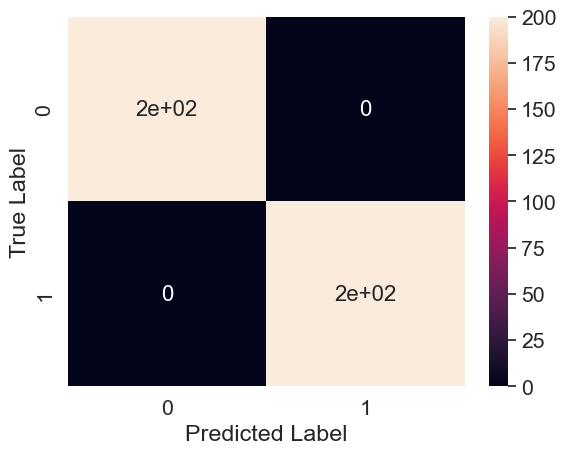

In [218]:
df_cm = pd.DataFrame(array, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()